# Load data, import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/kaggle/input/data-bounty-2-os-anomaly-detection/train.csv')
test = pd.read_csv('/kaggle/input/data-bounty-2-os-anomaly-detection/test.csv')
sample = pd.read_csv('/kaggle/input/data-bounty-2-os-anomaly-detection/submition_Sample.csv')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, roc_curve
from sklearn.utils import resample
import xgboost as xgb

/kaggle/input/data-bounty-2-os-anomaly-detection/train.csv
/kaggle/input/data-bounty-2-os-anomaly-detection/test.csv
/kaggle/input/data-bounty-2-os-anomaly-detection/submition_Sample.csv


# Utility functions

In [7]:
def undersample_dataset(X_train, y_train, ratio=5):
    """Undersample the majority class to a fixed ratio."""

    # Concatenate training data before undersampling
    df = pd.concat([X_train, y_train], axis=1)

    # Separate normal and anomalous entries
    normal = df[df.target == 0]
    anomaly = df[df.target == 1]

    # Downsample normal entries only
    normal_down = resample(
        normal,
        replace=False,
        n_samples=len(anomaly) * ratio,
        random_state=42
    )

    # Combine them back together, shuffle, then split again
    balanced = pd.concat([normal_down, anomaly]).sample(frac=1, random_state=42)
    X_balanced = balanced.drop("target", axis=1)
    y_balanced = balanced["target"]
    
    return X_balanced, y_balanced


def evaluate_thresholds(probs, y_true):
    """Determine the best threshold [0.01-0.99] based on the F1 score calculated on the predictions."""
    
    # Calculate F1 score at different thresholds
    thresholds = np.linspace(0.01, 0.99, 100)
    f1s = [f1_score(y_true, probs > t) for t in thresholds]

    # Get the threshold value that results in the best F1-score
    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.axvline(best_threshold, color='r', linestyle='--', label=f"Best: {best_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Threshold")
    plt.legend()
    plt.grid(True)
    #plt.show()

    print(f"Best threshold: {best_threshold:.2f} --> F1: {f1s[best_idx]:.3f}")
    return best_threshold


def plot_curves(probs, y_val):
    """Plot AUC and Precision/Recall curves"""

    # Caluclate: False Positive Ratio, True Positive Ratio, Precision and Recall
    fpr, tpr, _ = roc_curve(y_val, probs)
    precision, recall, _ = precision_recall_curve(y_val, probs)
    auc = roc_auc_score(y_val, probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()

# 1. Train/Test Split 

In [8]:
# Split original data into a training and a test set (both are labeled, test data will be left untouched)
train_df, test_df = train_test_split(train, test_size=0.25, stratify=train["target"], random_state=42)

X_train = train_df.drop("target", axis=1)
y_train = train_df["target"]

X_test = test_df.drop("target", axis=1)
y_test = test_df["target"]

# 2. Cross-Validation and Threshold Tuning

[Fold 1/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.98 --> F1: 0.849
[Fold 2/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.99 --> F1: 0.898
[Fold 3/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.99 --> F1: 0.902
[Fold 4/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.97 --> F1: 0.799
[Fold 5/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.99 --> F1: 0.823
[Fold 6/6]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best threshold: 0.74 --> F1: 0.896

CV Mean AUC: 0.9999243394542449
Best Threshold (from best AUC fold): 0.99


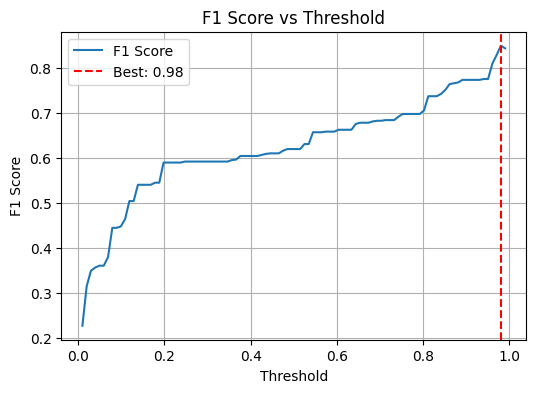

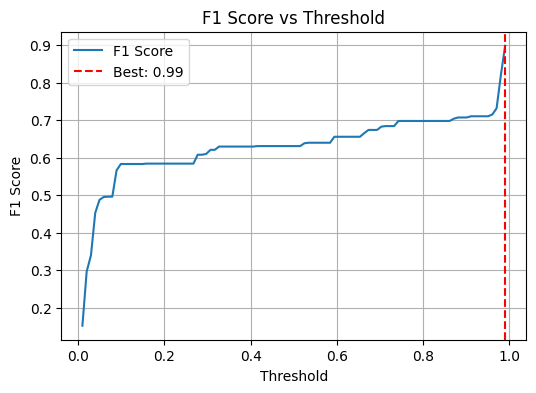

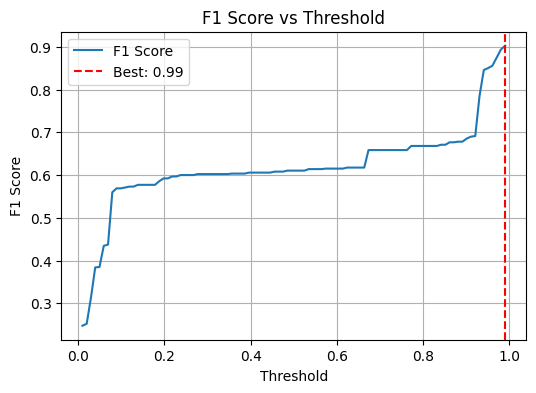

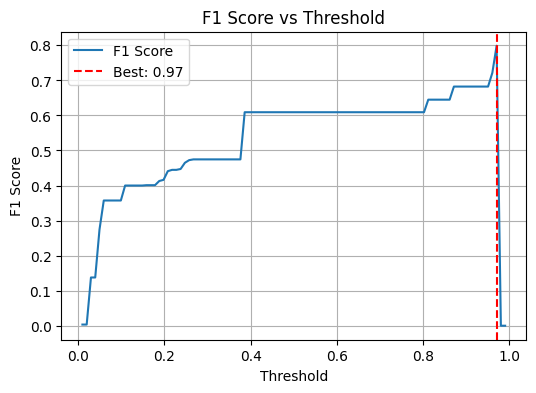

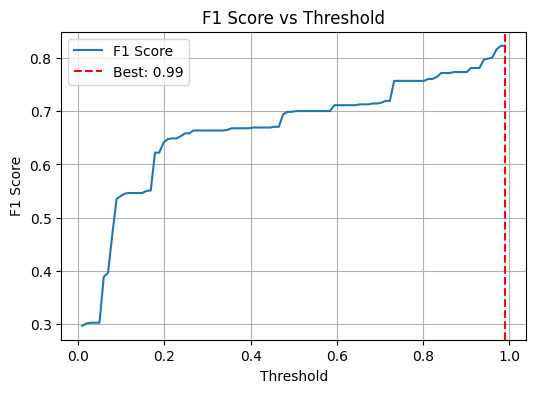

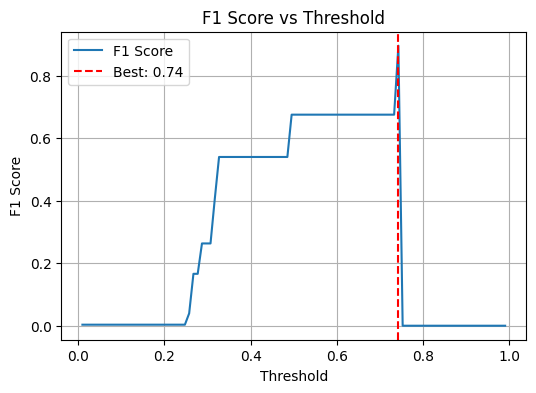

In [9]:
# Create stratified folds from the training data only
splits = 6
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Arrays for saving best scores from CV folds
aucs = []
thresholds = []

# CV + XGBoost for selecting the best threshold and model parameters
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"[Fold {fold+1}/{splits}]")

    # Select training and validation data based on the shuffled CV indices
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # Undersample training data + calculate scale_pos_weight for XGB
    X_tr_us, y_tr_us = undersample_dataset(X_tr, y_tr)
    spw = (y_tr_us == 0).sum() / (y_tr_us == 1).sum()

    model = xgb.XGBClassifier(eval_metric='auc', scale_pos_weight=spw)
    model.fit(
        X_tr_us, y_tr_us,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )

    # Evaluation
    probs = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, probs)
    aucs.append(auc)
    
    best_thresh = evaluate_thresholds(probs, y_val)
    thresholds.append(best_thresh)

print("\nCV Mean AUC:", np.mean(aucs))
print("Best Threshold (from best AUC fold):", thresholds[np.argmax(aucs)])

# 3. Final model training

Final mpdel training with the selected threshold

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Final Test ROC AUC: 0.99992253059288


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190469
           1       0.00      0.00      0.00       317

    accuracy                           1.00    190786
   macro avg       0.50      0.50      0.50    190786
weighted avg       1.00      1.00      1.00    190786



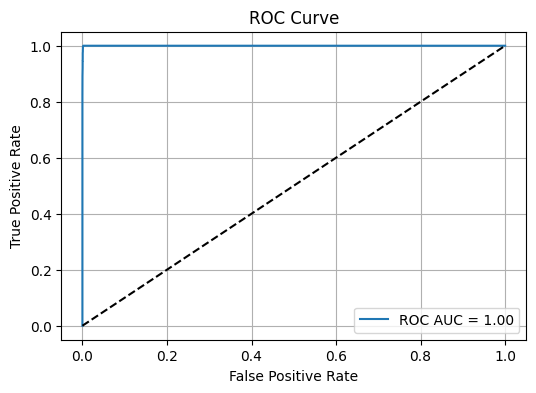

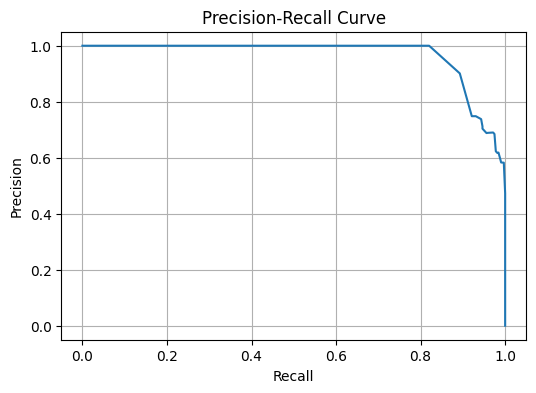

In [10]:
# Undersample the full training dataset
X_us, y_us = undersample_dataset(X_train, y_train)

# split dataset for threshold tuning
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(X_us, y_us, test_size=0.2, stratify=y_us, random_state=42)

# Calculate scale_pos_weight
spw = (y_us == 0).sum() / (y_us == 1).sum()

final_model = xgb.XGBClassifier(eval_metric='auc', scale_pos_weight=spw)
final_model.fit(
    X_tr_final, y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    early_stopping_rounds=10,
    verbose=False
)

# Finding best threshold
final_probs = final_model.predict_proba(X_test)[:, 1]
highest_threshold_idx = np.argmax(aucs)
highest_threshold = thresholds[highest_threshold_idx]
final_preds = (final_probs > highest_threshold).astype(int)

print("\nFinal Test ROC AUC:", roc_auc_score(y_test, final_probs))
print(classification_report(y_test, final_preds))

plot_curves(final_probs, y_test)

# Submission

In [11]:
submission_preds = final_model.predict_proba(test)[:, 1]
submission_preds = (submission_preds > highest_threshold).astype(int)

In [34]:
submission_preds = final_model.predict(test)

submission_df = test.filter(like="processId")
submission_df.loc[:, "target"] = pd.DataFrame(data=submission_preds)

submission_df.to_csv('/kaggle/working/submission_250610.csv')

/tmp/ipykernel_35/2788777641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.loc[:, "target"] = pd.DataFrame(data=submission_preds)
